# Feature variation by substitution ($\nu_{\phi}$)

## 1 Setup

Flags and settings

In [1]:
SAVE_FIGURES = False
PAPER_FEATURES = ['frequency', 'aoa', 'clustering', 'letters_count', 'synonyms_count']
N_COMPONENTS = 3

Imports and database setup

In [2]:
import pandas as pd
import seaborn as sb
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from progressbar import ProgressBar

%cd -q ..
from brainscopypaste.conf import settings
%cd -q notebooks
from brainscopypaste.mine import Model, Time, Source, Past, Durl
from brainscopypaste.db import Substitution
from brainscopypaste.utils import init_db, session_scope
engine = init_db()

## 2 Variation of features upon substitution

First build our data

In [3]:
model = Model(Time.discrete, Source.majority, Past.last_bin, Durl.all)
data = []

with session_scope() as session:
    substitutions = session.query(Substitution.id).filter(Substitution.model == model)
    print("Got {} substitutions for model {}".format(substitutions.count(), model))
    substitution_ids = [id for (id,) in substitutions]

for substitution_id in ProgressBar()(substitution_ids):
    with session_scope() as session:
        substitution = session.query(Substitution).get(substitution_id)
        
        for feature in Substitution.__features__:
            source, destination = substitution.features(feature)
            data.append({'cluster_id': substitution.source.cluster.sid,
                         'destination_id': substitution.destination.sid,
                         'occurrence': substitution.occurrence,
                         'source_id': substitution.source.sid,
                         'feature': feature,
                         'source': source,
                         'destination': destination})

original_variations = pd.DataFrame(data)
del data

Got 9071 substitutions for model Model(time=Time.discrete, source=Source.majority, past=Past.last_bin, durl=Durl.all)


100% (9071 of 9071) |#######################################################################################################################################| Elapsed Time: 0:01:03 Time: 0:01:03


In [4]:
variations = original_variations\
    .groupby(['destination_id', 'occurrence', 'feature'], as_index=False).mean()\
    .groupby(['cluster_id', 'feature'], as_index=False)\
    ['destination', 'source', 'feature'].mean()
variations['variation'] = variations['destination'] - variations['source']

# HARDCODED: drop values where destination AoA is above 14.
# This crops the graphs to acceptable ICs.
variations.loc[(variations.feature == 'aoa') & (variations.destination > 14),
               ['destination', 'source', 'variation']] = np.nan

variations.head()

,cluster_id,feature,destination,source,variation
0,662,aoa,NaN,NaN,NaN
1,662,betweenness,-7.695924,-9.572382,1.876458
2,662,clustering,-5.279287,-4.836344,-0.442943
3,662,degree,-7.883823,-7.324207,-0.559616
4,662,frequency,6.960348,8.617762,-1.657415


### 2.1 What we plot about features

For a feature $\phi$, plot:

* $\nu_{\phi}$, the variation of the feature upon substitution
* $\nu_{\phi}^0$ (which is the average feature value), i.e. what happens under $\mathcal{H}_0$
* $\nu_{\phi}^{00}$ (which is the average feature value for neighbours of the words with $\phi(w) = x$), i.e. what happens under $\mathcal{H}_{00}$
* $y = x$, i.e. what happens if there is no substitution

In [5]:
def plot_variation(x, y, **kwargs):
    data = kwargs.pop('data')
    feature = data.iloc[0].feature
    color = kwargs.get('color', 'blue')
    x = data[x]
    y = data[y]
    
    # Compute binning.
    bin_count = 4
    x_bins, bins = pd.cut(x, bin_count, right=False, labels=False, retbins=True)
    middles = (bins[:-1] + bins[1:]) / 2
    
    # Compute bin values.
    h0s = Substitution.feature_average(feature) * np.ones(bin_count)
    h0ns = np.zeros(bin_count)
    values = np.zeros(bin_count)
    cis = np.zeros(bin_count)
    for i in range(bin_count):
        values[i] = y[x_bins == i].mean()
        cis[i] = 1.96 * y[x_bins == i].std() / np.sqrt((x_bins == i).sum() - 1)
        h0ns[i] = Substitution.feature_average(feature, synonyms_from_range=(bins[i], bins[i+1]))
    
    # Plot.
    plt.plot(middles, values, '-', lw=2, color=color, label=r'$\nu_{\phi}$')
    plt.fill_between(middles, values - cis, values + cis,
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.plot(middles, h0s, '--', color=sb.desaturate(color, 0.2),
             label=r'$\nu_{\phi}^0$')
    plt.plot(middles, h0ns, linestyle='-.', color=sb.desaturate(color, 0.2),
             label=r'$\nu_{\phi}^{00}$')
    plt.plot(middles, middles, linestyle='dotted', color=sb.desaturate(color, 0.2),
             label=r'$y = x$')
    lmin, lmax = middles[0], middles[-1]
    h0min, h0max = min(h0s.min(), h0ns.min()), max(h0s.max(), h0ns.max())
    # Rescale limits if we're touching H0 or H00.
    if h0min < lmin:
        lmin = h0min - (lmax - h0min) / 10
    elif h0max > lmax:
        lmax = h0max + (h0max - lmin) / 10
    plt.xlim(lmin, lmax)
    plt.ylim(lmin, lmax)

### 2.2 Real feature variations

For each feature $\phi$, we plot the variation upon substitution as explained above

#### 2.2.1 On all the features

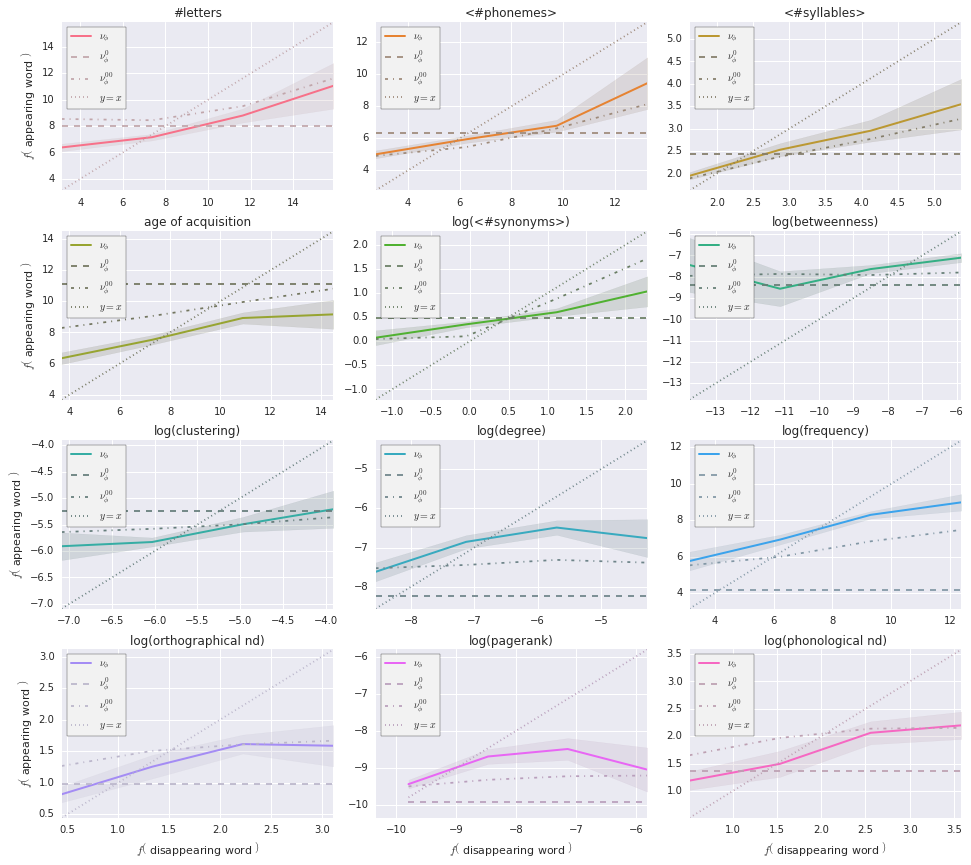

In [6]:
ordered_features = sorted(Substitution.__features__,
                          key=lambda f: Substitution._transformed_feature(f).__doc__)
g = sb.FacetGrid(data=variations, col='feature', col_wrap=3,
                 sharex=False, sharey=False, hue='feature',
                 aspect=1.5, size=3,
                 col_order=ordered_features, hue_order=ordered_features)
g.map_dataframe(plot_variation, 'source', 'destination')
g.set_titles('{col_name}')
g.set_xlabels(r'$f \left( \right.$ disappearing word $\left. \right)$')
g.set_ylabels(r'$f \left( \right.$ appearing word $\left. \right)$')
for ax in g.axes.ravel():
    legend = ax.legend(frameon=True, loc='upper left')
    if not legend:
        # Skip if nothing was plotted on these axes.
        continue
    frame = legend.get_frame()
    frame.set_facecolor('#f2f2f2')
    frame.set_edgecolor('#000000')
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)

Then plot $\nu_{\phi} - \nu_{\phi}^{00}$ for each feature (i.e. the measured bias) to see how they compare

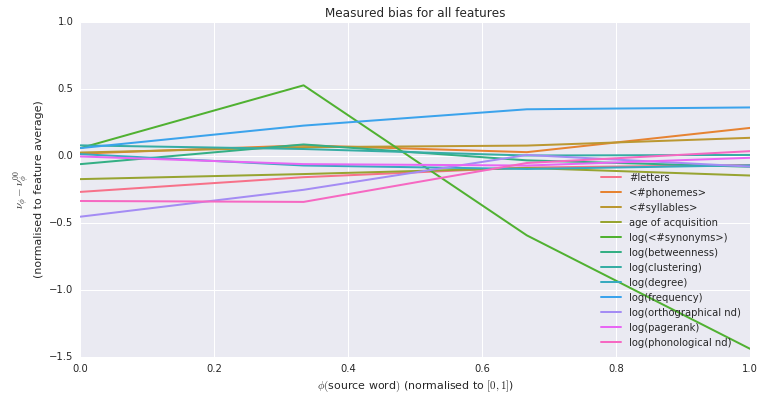

In [7]:
palette = sb.color_palette('husl', len(Substitution.__features__))
fig, ax = plt.subplots(figsize=(12, 6))
for j, feature in enumerate(ordered_features):
    x = variations[variations['feature'] == feature]['source']
    y = variations[variations['feature'] == feature]['destination']
    
    # Compute binning.
    bin_count = 4
    x_bins, bins = pd.cut(x, bin_count, right=False, labels=False, retbins=True)
    
    # Compute bin values.
    h0 = Substitution.feature_average(feature)
    h0ns = np.zeros(bin_count)
    values = np.zeros(bin_count)
    #cis = np.zeros(bin_count)
    for i in range(bin_count):
        values[i] = y[x_bins == i].mean()
        #cis[i] = 1.96 * y[x_bins == i].std() / np.sqrt((x_bins == i).sum() - 1)
        h0ns[i] = Substitution.feature_average(feature, synonyms_from_range=(bins[i], bins[i+1]))
    
    # Plot.
    ax.plot(np.linspace(0, 1, bin_count), (values - h0ns) / h0, '-', lw=2, color=palette[j],
            label=Substitution._transformed_feature(feature).__doc__)

ax.legend(loc='lower right')
ax.set_title('Measured bias for all features')
ax.set_xlabel(r'$\phi($source word$)$ (normalised to $[0, 1]$)')
ax.set_ylabel(r'$\nu_{\phi} - \nu_{\phi}^{00}$' + '\n(normalised to feature average)')

#### 2.2.2 On the features we expose in the paper

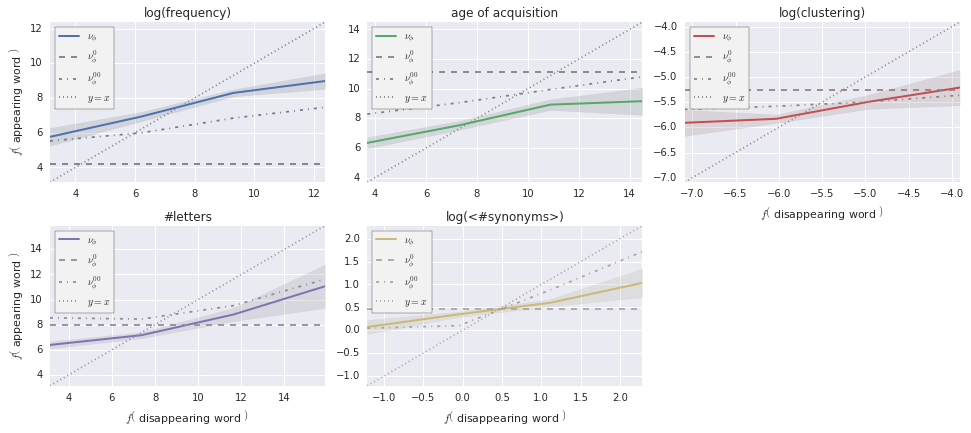

In [8]:
g = sb.FacetGrid(data=variations[variations['feature'].map(lambda f: f in PAPER_FEATURES)],
                 col='feature', col_wrap=3,
                 sharex=False, sharey=False, hue='feature',
                 aspect=1.5, size=3,
                 col_order=PAPER_FEATURES, hue_order=PAPER_FEATURES)
g.map_dataframe(plot_variation, 'source', 'destination')
g.set_titles('{col_name}')
g.set_xlabels(r'$f \left( \right.$ disappearing word $\left. \right)$')
g.set_ylabels(r'$f \left( \right.$ appearing word $\left. \right)$')
for ax in g.axes.ravel():
    legend = ax.legend(frameon=True, loc='upper left')
    if not legend:
        # Skip if nothing was plotted on these axes.
        continue
    frame = legend.get_frame()
    frame.set_facecolor('#f2f2f2')
    frame.set_edgecolor('#000000')
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)

Now $\nu_{\phi} - \nu_{\phi}^{00}$

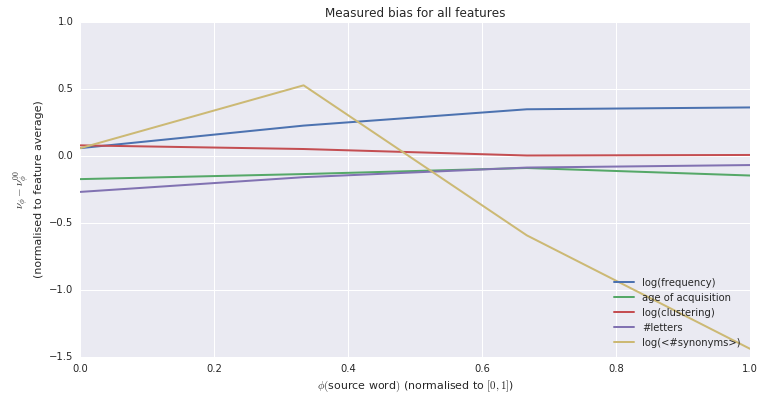

In [9]:
palette = sb.color_palette('deep', len(PAPER_FEATURES))
fig, ax = plt.subplots(figsize=(12, 6))
for j, feature in enumerate(PAPER_FEATURES):
    x = variations[variations['feature'] == feature]['source']
    y = variations[variations['feature'] == feature]['destination']
    
    # Compute binning.
    bin_count = 4
    x_bins, bins = pd.cut(x, bin_count, right=False, labels=False, retbins=True)
    
    # Compute bin values.
    h0 = Substitution.feature_average(feature)
    h0ns = np.zeros(bin_count)
    values = np.zeros(bin_count)
    #cis = np.zeros(bin_count)
    for i in range(bin_count):
        values[i] = y[x_bins == i].mean()
        #cis[i] = 1.96 * y[x_bins == i].std() / np.sqrt((x_bins == i).sum() - 1)
        h0ns[i] = Substitution.feature_average(feature, synonyms_from_range=(bins[i], bins[i+1]))
    
    # Plot.
    ax.plot(np.linspace(0, 1, bin_count), (values - h0ns) / h0, '-', lw=2, color=palette[j],
            label=Substitution._transformed_feature(feature).__doc__)

ax.legend(loc='lower right')
ax.set_title('Measured bias for all features')
ax.set_xlabel(r'$\phi($source word$)$ (normalised to $[0, 1]$)')
ax.set_ylabel(r'$\nu_{\phi} - \nu_{\phi}^{00}$' + '\n(normalised to feature average)')

### 2.3 PCA'd feature variations

Compute PCA on feature *variations* (note: on variations, not on features directly), and show the evolution of the first three components upon substitution

Our plotting function

In [10]:
def plot_component_variation(x, y, **kwargs):
    data = kwargs['data']
    pca = kwargs['pca']
    features = kwargs['features']
    component = int(data.iloc[0].component)
    color = kwargs.get('color', 'blue')
    x = data[x]
    y = data[y]
    
    # Compute binning.
    bin_count = 4
    x_bins, bins = pd.cut(x, bin_count, right=False, labels=False, retbins=True)
    middles = (bins[:-1] + bins[1:]) / 2
    
    # Compute bin values.
    h0 = pca.transform(np.array([Substitution.feature_average(feature)
                                 for feature in sorted(features)])
                       [np.newaxis, :])[0, component]
    values = np.zeros(bin_count)
    cis = np.zeros(bin_count)
    for i in range(bin_count):
        values[i] = y[x_bins == i].mean()
        cis[i] = 1.96 * y[x_bins == i].std() / np.sqrt((x_bins == i).sum() - 1)
    
    # Plot.
    plt.plot(middles, values, '-', lw=2, color=color, label=r'$\nu_{\phi}$')
    plt.fill_between(middles, values - cis, values + cis,
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.plot(middles, h0 * np.ones(bin_count), '--', color=sb.desaturate(color, 0.2),
             label=r'$\nu_{\phi}^0$')
    plt.plot(middles, middles, linestyle='dotted', color=sb.desaturate(color, 0.2),
             label=r'$y = x$')
    # Rescale limits if we're touching H0.
    lmin, lmax = middles[0], middles[-1]
    if h0 < lmin:
        lmin = h0 - (lmax - h0) / 10
    elif h0 > lmax:
        lmax = h0 + (h0 - lmin) / 10
    plt.xlim(lmin, lmax)
    plt.ylim(lmin, lmax)

#### 2.3.1 On all the features

Compute the actual PCA

In [11]:
# Compute the PCA.
pcavariations = variations.pivot(index='cluster_id', columns='feature', values='variation')
pcavariations = pcavariations.dropna()
pca = PCA(n_components='mle')
pca.fit(pcavariations)

# Show 
print('MLE estimates there are {} components.\n'.format(pca.n_components_))
print('Those explain the following variance:')
print(pca.explained_variance_ratio_)
print()

print("We're plotting variation for the first {} components:".format(N_COMPONENTS))
pd.DataFrame(pca.components_[:N_COMPONENTS],
             columns=sorted(Substitution.__features__),
             index=['Component-{}'.format(i) for i in range(N_COMPONENTS)])

MLE estimates there are 11 components.

Those explain the following variance:
[ 0.51446555  0.17489229  0.09027657  0.07328873  0.03525223  0.03035294
  0.02269237  0.01956296  0.01551358  0.01115776  0.0074942 ]

We're plotting variation for the first 3 components:


,aoa,betweenness,clustering,degree,frequency,letters_count,orthographical_density,pagerank,phonemes_count,phonological_density,syllables_count,synonyms_count
Component-0,-0.494620,0.285122,-0.096906,0.244552,0.220021,-0.428082,0.209175,0.260700,-0.394800,0.281829,-0.161557,0.009108
Component-1,-0.376832,0.347266,-0.102316,0.279024,0.226340,0.457246,-0.161054,0.302833,0.446615,-0.218316,0.153843,-0.018360
Component-2,-0.533138,-0.059417,0.030610,-0.028758,-0.835564,0.075649,0.004000,-0.056422,-0.009812,-0.042775,-0.007291,0.037434


Create the PCA'd DataFrame with source and destination values for each substitution

In [12]:
components_dict = {}
# Compute source and destination components.
for value_name in ['source', 'destination']:
    components = pca.transform(variations
                               .pivot(index='cluster_id', columns='feature', values=value_name)
                               .loc[pcavariations.index])
    df = pd.DataFrame(components[:, :N_COMPONENTS], columns=range(N_COMPONENTS))
    df['cluster_id'] = pcavariations.index
    components_dict[value_name] = pd.melt(df, id_vars='cluster_id',
                                          var_name='component', value_name=value_name)

# Initialize final DataFrame with source components.
component_variations = components_dict['source']
# Add the 'destination' column.
component_variations['destination'] = components_dict['destination']['destination']

Plot the actual variations of components

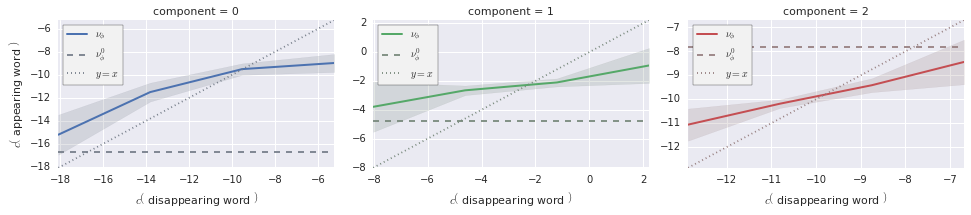

In [13]:
g = sb.FacetGrid(data=component_variations, col='component', col_wrap=3,
                 sharex=False, sharey=False, hue='component',
                 aspect=1.5, size=3)
g.map_dataframe(plot_component_variation, 'source', 'destination', pca=pca,
                features=Substitution.__features__)
g.set_xlabels(r'$c \left( \right.$ disappearing word $\left. \right)$')
g.set_ylabels(r'$c \left( \right.$ appearing word $\left. \right)$')
for ax in g.axes.ravel():
    legend = ax.legend(frameon=True, loc='upper left')
    if not legend:
        # Skip if nothing was plotted on these axes.
        continue
    frame = legend.get_frame()
    frame.set_facecolor('#f2f2f2')
    frame.set_edgecolor('#000000')

#### 2.3.2 On the features we expose in the paper

In [14]:
# Compute the PCA.
pcavariations = variations[variations['feature'].map(lambda f: f in PAPER_FEATURES)]\
    .pivot(index='cluster_id', columns='feature', values='variation')
pcavariations = pcavariations.dropna()
pca = PCA(n_components='mle')
pca.fit(pcavariations)

# Show 
print('MLE estimates there are {} components.\n'.format(pca.n_components_))
print('Those explain the following variance:')
print(pca.explained_variance_ratio_)
print()

print("We're plotting variation for the first {} components:".format(N_COMPONENTS))
pd.DataFrame(pca.components_[:N_COMPONENTS],
             columns=sorted(PAPER_FEATURES),
             index=['Component-{}'.format(i) for i in range(N_COMPONENTS)])

MLE estimates there are 3 components.

Those explain the following variance:
[ 0.5611224   0.20252396  0.16394234]

We're plotting variation for the first 3 components:


,aoa,clustering,frequency,letters_count,synonyms_count
Component-0,-0.739326,-0.107439,0.309141,-0.588358,0.011020
Component-1,0.606435,0.075497,-0.028362,-0.790948,-0.011570
Component-2,-0.277713,0.134746,-0.935993,-0.166911,0.027867


In [15]:
components_dict = {}
# Compute source and destination components.
for value_name in ['source', 'destination']:
    components = pca.transform(variations
                               [variations['feature'].map(lambda f: f in PAPER_FEATURES)]
                               .pivot(index='cluster_id', columns='feature', values=value_name)
                               .loc[pcavariations.index])
    df = pd.DataFrame(components[:, :N_COMPONENTS], columns=range(N_COMPONENTS))
    df['cluster_id'] = pcavariations.index
    components_dict[value_name] = pd.melt(df, id_vars='cluster_id',
                                          var_name='component', value_name=value_name)

# Initialize final DataFrame with source components.
component_variations = components_dict['source']
# Add the 'destination' column.
component_variations['destination'] = components_dict['destination']['destination']

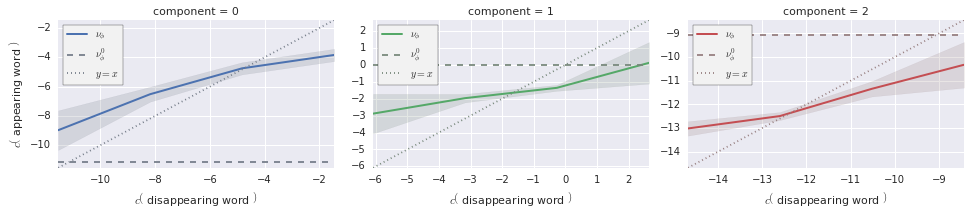

In [16]:
g = sb.FacetGrid(data=component_variations, col='component', col_wrap=3,
                 sharex=False, sharey=False, hue='component',
                 aspect=1.5, size=3)
g.map_dataframe(plot_component_variation, 'source', 'destination', pca=pca,
                features=PAPER_FEATURES)
g.set_xlabels(r'$c \left( \right.$ disappearing word $\left. \right)$')
g.set_ylabels(r'$c \left( \right.$ appearing word $\left. \right)$')
for ax in g.axes.ravel():
    legend = ax.legend(frameon=True, loc='upper left')
    if not legend:
        # Skip if nothing was plotted on these axes.
        continue
    frame = legend.get_frame()
    frame.set_facecolor('#f2f2f2')
    frame.set_edgecolor('#000000')